In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
target_gu = '' # 구 명
target_dong = '' # 동 명: 동 명에서 마지막 글자 '동' 뺄 것
#target_purpose = '준주거' # 종 명: 건드릴 필요 없음
target_building_age = 5 # 건물연식: 건드릴 필요 없음
target_period = 36 # 계약날짜 검색범위: 건드릴 필요 없음
target_starting_year = 2015 # 검색 시작 계약 년도: 건드릴 필요 없음

In [3]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [4]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20211122'

In [5]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [6]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [8]:
def data_prep(bdtype, tradetype, starting_year=2015):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    if (tradetype != '매매') & (tradetype != '전월세'):
        raise ValueError('두번째 변수는 매매 또는 전월세만 입력 가능')
    
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        splitted_filename = f.split('실거래가_')       
        file_year = int(splitted_filename[-1][:4])
        
        if file_year < starting_year:
            continue
        
        try:
            df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        except:
            try:
                df = pd.read_csv(basedir + f, encoding='utf-8', header=15)
            except:
                df = pd.read_csv(basedir + f, header=15)
        
        if '건물명' in df.columns:
            df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
        elif '단지명' in df.columns:
            df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
            
        if '대지권면적(㎡)' in df.columns:
            df = df.drop(columns=['대지권면적(㎡)'])
                
            
        '''if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])'''
            
        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
    
    if tradetype == '전월세':
        concat_df = concat_df.rename(columns={'전월세구분':'거래구분', '보증금(만원)':'거래금액(만원)'})
        concat_df = concat_df.drop(columns=['월세(만원)'])
        concat_df = concat_df[concat_df['거래구분'] == '전세']
    elif tradetype == '매매':
        concat_df['거래구분'] = '매매'
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].astype('Int64')
    concat_df['계약일'] = concat_df['계약일'].astype('Int64')
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['번지', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    #concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [9]:
apart_trade_df = data_prep('아파트', '매매')
#apart_lease_df = data_prep('아파트', '전월세')
apart_df = pd.concat([apart_trade_df]).reset_index(drop=True)
del apart_trade_df
apart_df['부동산유형'] = '아파트'
print(apart_df.shape)
apart_df.head()

16it [00:01, 12.86it/s]


(617355, 19)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,해제사유발생일,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 655-2,언주로 103,서울특별시 강남구 개포동,655.0,2.0,개포2차현대아파트(220),77.75,60000,5,1988,NaN,-,-,매매,27,2015-01-11,771.704180,33,아파트
1,서울특별시 강남구 개포동 655-2,언주로 103,서울특별시 강남구 개포동,655.0,2.0,개포2차현대아파트(220),77.75,65000,5,1988,NaN,-,-,매매,27,2015-03-03,836.012862,33,아파트
2,서울특별시 강남구 개포동 655-2,언주로 103,서울특별시 강남구 개포동,655.0,2.0,개포2차현대아파트(220),77.75,62500,2,1988,NaN,-,-,매매,27,2015-03-07,803.858521,33,아파트
3,서울특별시 강남구 개포동 655-2,언주로 103,서울특별시 강남구 개포동,655.0,2.0,개포2차현대아파트(220),77.75,68000,6,1988,NaN,-,-,매매,27,2015-08-16,874.598071,33,아파트
4,서울특별시 강남구 개포동 658-1,언주로 3,서울특별시 강남구 개포동,658.0,1.0,개포6차우성아파트1동~8동,79.97,73000,5,1987,NaN,-,-,매매,28,2015-01-29,912.842316,34,아파트


In [10]:
yunrip_trade_df = data_prep('연립다세대', '매매')
#yunrip_lease_df = data_prep('연립다세대', '전월세')
yunrip_df = pd.concat([yunrip_trade_df]).reset_index(drop=True)
del yunrip_trade_df#, yunrip_lease_df
yunrip_df['부동산유형'] = '연립다세대'
print(yunrip_df.shape)
yunrip_df.head()

16it [00:00, 16.41it/s]


(369514, 19)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,해제사유발생일,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 1216-4,개포로26길 16,서울특별시 강남구 개포동,1216,4,(1216-4),33.77,24800,4,2012.0,NaN,-,-,매매,3.0,2015-03-26,734.379627,9.0,연립다세대
1,서울특별시 강남구 개포동 1216-4,개포로26길 16,서울특별시 강남구 개포동,1216,4,(1216-4),35.87,27200,4,2012.0,NaN,-,-,매매,3.0,2015-06-23,758.293839,9.0,연립다세대
2,서울특별시 강남구 개포동 1216-4,개포로26길 16,서울특별시 강남구 개포동,1216,4,(1216-4),29.12,22200,4,2012.0,NaN,-,-,매매,3.0,2015-07-20,762.362637,9.0,연립다세대
3,서울특별시 강남구 개포동 1216-4,개포로26길 16,서울특별시 강남구 개포동,1216,4,(1216-4),29.97,22500,3,2012.0,NaN,-,-,매매,3.0,2015-08-06,750.750751,9.0,연립다세대
4,서울특별시 강남구 개포동 170-18,선릉로12길 17,서울특별시 강남구 개포동,170,18,(170-18),26.60,21000,1,1988.0,NaN,-,-,매매,27.0,2015-08-21,789.473684,33.0,연립다세대


In [11]:
officetel_trade_df = data_prep('오피스텔', '매매')
#officetel_lease_df = data_prep('오피스텔', '전월세')
officetel_df = pd.concat([officetel_trade_df]).reset_index(drop=True)
del officetel_trade_df#, officetel_lease_df
officetel_df['부동산유형'] = '오피스텔'
print(officetel_df.shape)
officetel_df.head()

16it [00:00, 65.83it/s] 


(90835, 19)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,해제사유발생일,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 13-3,개포로 623,서울특별시 강남구 개포동,13,3,대청타워,43.24,22000,14,1997.0,NaN,-,-,매매,18.0,2015-01-08,508.788159,24.0,오피스텔
1,서울특별시 강남구 개포동 13-3,개포로 623,서울특별시 강남구 개포동,13,3,대청타워,32.44,15800,21,1997.0,NaN,-,-,매매,18.0,2015-01-12,487.053021,24.0,오피스텔
2,서울특별시 강남구 개포동 13-3,개포로 623,서울특별시 강남구 개포동,13,3,대청타워,32.44,16000,10,1997.0,NaN,-,-,매매,18.0,2015-01-19,493.218249,24.0,오피스텔
3,서울특별시 강남구 개포동 13-3,개포로 623,서울특별시 강남구 개포동,13,3,대청타워,32.44,15400,21,1997.0,NaN,-,-,매매,18.0,2015-01-26,474.722565,24.0,오피스텔
4,서울특별시 강남구 개포동 13-3,개포로 623,서울특별시 강남구 개포동,13,3,대청타워,31.91,16000,26,1997.0,NaN,-,-,매매,18.0,2015-01-28,501.410216,24.0,오피스텔


In [12]:
house_df = pd.concat([apart_df, yunrip_df, officetel_df]).sort_values(['시군구', '본번', '부번', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
del apart_df, yunrip_df, officetel_df
print(house_df.shape)
house_df.head()

(1077704, 19)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,해제사유발생일,거래유형,중개사소재지,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,35000,13,1992.0,NaN,-,-,매매,23.0,2015-01-26,1054.852321,29.0,아파트
1,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,34500,14,1992.0,NaN,-,-,매매,23.0,2015-01-27,1039.783002,29.0,아파트
2,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,36000,11,1992.0,NaN,-,-,매매,23.0,2015-01-31,1084.990958,29.0,아파트
3,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,35500,10,1992.0,NaN,-,-,매매,23.0,2015-02-03,1069.921640,29.0,아파트
4,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,35000,9,1992.0,NaN,-,-,매매,23.0,2015-02-14,1054.852321,29.0,아파트


In [13]:
house_df = house_df.drop(columns=['거래유형', '중개사소재지'])
print(house_df.shape)
house_df.head()

(1077704, 17)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,해제사유발생일,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,35000,13,1992.0,NaN,매매,23.0,2015-01-26,1054.852321,29.0,아파트
1,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,34500,14,1992.0,NaN,매매,23.0,2015-01-27,1039.783002,29.0,아파트
2,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,36000,11,1992.0,NaN,매매,23.0,2015-01-31,1084.990958,29.0,아파트
3,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,35500,10,1992.0,NaN,매매,23.0,2015-02-03,1069.921640,29.0,아파트
4,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,35000,9,1992.0,NaN,매매,23.0,2015-02-14,1054.852321,29.0,아파트


In [24]:
nonan_df = house_df[house_df['해제사유발생일'].isna() == False]
print(nonan_df.shape)
nonan_df.head()

(10951, 17)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,해제사유발생일,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
252,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,111000,12,1992.0,20210521.0,매매,29.0,2021-01-21,3345.388788,29.0,아파트
270,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,119500,3,1992.0,20211112.0,매매,29.0,2021-08-04,3601.567209,29.0,아파트
626,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,39.53,100000,1,1992.0,20201030.0,매매,28.0,2020-06-13,2529.724260,29.0,아파트
628,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,39.53,110000,7,1992.0,20200714.0,매매,28.0,2020-06-15,2782.696686,29.0,아파트
632,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,39.53,118000,11,1992.0,20200731.0,매매,28.0,2020-07-03,2985.074627,29.0,아파트


In [25]:
nonan_df['해제사유발생일'] = pd.to_datetime(nonan_df['해제사유발생일'], format='%Y%m%d')

In [26]:
print(nonan_df.shape)
nonan_df.head()

(10951, 17)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,해제사유발생일,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
252,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,111000,12,1992.0,2021-05-21,매매,29.0,2021-01-21,3345.388788,29.0,아파트
270,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,119500,3,1992.0,2021-11-12,매매,29.0,2021-08-04,3601.567209,29.0,아파트
626,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,39.53,100000,1,1992.0,2020-10-30,매매,28.0,2020-06-13,2529.724260,29.0,아파트
628,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,39.53,110000,7,1992.0,2020-07-14,매매,28.0,2020-06-15,2782.696686,29.0,아파트
632,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,39.53,118000,11,1992.0,2020-07-31,매매,28.0,2020-07-03,2985.074627,29.0,아파트


In [27]:
nonan_df['계약날짜와의차이'] = nonan_df['해제사유발생일'] - nonan_df['계약날짜']

In [28]:
print(nonan_df.shape)
nonan_df.head()

(10951, 18)


,지번주소,도로명,시군구,본번,부번,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,해제사유발생일,거래구분,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,계약날짜와의차이
252,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,111000,12,1992.0,2021-05-21,매매,29.0,2021-01-21,3345.388788,29.0,아파트,120 days
270,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,33.18,119500,3,1992.0,2021-11-12,매매,29.0,2021-08-04,3601.567209,29.0,아파트,100 days
626,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,39.53,100000,1,1992.0,2020-10-30,매매,28.0,2020-06-13,2529.724260,29.0,아파트,139 days
628,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,39.53,110000,7,1992.0,2020-07-14,매매,28.0,2020-06-15,2782.696686,29.0,아파트,29 days
632,서울특별시 강남구 개포동 12-0,개포로109길 9,서울특별시 강남구 개포동,12.0,0.0,성원대치2단지아파트,39.53,118000,11,1992.0,2020-07-31,매매,28.0,2020-07-03,2985.074627,29.0,아파트,28 days


In [33]:
nonan_df['계약날짜와의차이'] = nonan_df['계약날짜와의차이'].dt.days

In [35]:
nonan_df['계약날짜와의차이'].dtype

dtype('int64')

<AxesSubplot:>

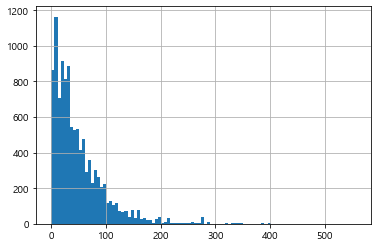

In [37]:
nonan_df['계약날짜와의차이'].hist(bins=100)

In [41]:
nonan_df['계약날짜와의차이'].quantile(0.75)

68.0

In [ ]:
'''land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()'''

In [ ]:
'''last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()'''

In [ ]:
'''house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)'''

In [ ]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
#house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
#house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [ ]:
house_df['일괄계약'] = 'N'

In [ ]:
#house_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)

In [ ]:
'''print(house_df.shape)
house_df.head()'''

In [ ]:
def identify_bulk_contract(df):
    df = df.copy()
    
    for addr in tqdm(df['지번주소'].unique()):
        addr_df = df[df['지번주소'] == addr]
        
        for btyear in addr_df['건축년도'].unique():
            btyear_df = addr_df[addr_df['건축년도'] == btyear]
        
            for contract_date in btyear_df['계약날짜'].unique():
                contract_date_df = btyear_df[btyear_df['계약날짜'] == contract_date]

                if contract_date_df.shape[0] >= 5:
                    df.loc[contract_date_df.index, '일괄계약'] = 'Y'
    
    return df

In [ ]:
target_1_12_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=6)))
    &(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_1_12_df.shape)
target_1_12_df.head()

In [ ]:
target_2_24_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=12)))
    &(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_2_24_df.shape)
target_2_24_df.head()

In [ ]:
target_3_36_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=24)))
    &(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_3_36_df.shape)
target_3_36_df.head()

In [ ]:
target_5_60_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=36)))
    &(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_5_60_df.shape)
target_5_60_df.head()

In [ ]:
target_1_12_df = identify_bulk_contract(target_1_12_df)
print(target_1_12_df.shape)

In [ ]:
target_2_24_df = identify_bulk_contract(target_2_24_df)
print(target_2_24_df.shape)

In [ ]:
target_3_36_df = identify_bulk_contract(target_3_36_df)
print(target_3_36_df.shape)

In [ ]:
target_5_60_df = identify_bulk_contract(target_5_60_df)
print(target_5_60_df.shape)

In [ ]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]

sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])

sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

sales_idx_df.columns = sales_idx_cols_list

In [ ]:
print(sales_idx_df.shape)
sales_idx_df.head()

In [ ]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        try:
            idx = df[year+'년 '+month+'월_지수'].iloc[0]
            return idx
        
        except:
            return '지수없음'

In [ ]:
def get_index_applied_prices(df):
    df = df.copy()
    
    last_idx = sales_idx_df.iloc[0,-2]
    
    df['계약날짜_실거래지수'] = df['계약날짜'].apply(get_sales_idx)
    
    df_idx_positive = df[df['계약날짜_실거래지수'] != '지수없음']
    
    df['지수적용단가'] = df['단가(만원/㎡)']
    
    df_idx_positive['지수적용단가'] = df_idx_positive['단가(만원/㎡)'] / df_idx_positive['계약날짜_실거래지수'] * last_idx
    
    df.loc[df_idx_positive.index, '지수적용단가'] = df_idx_positive['지수적용단가']
    
    df['지수적용단가'] = df['지수적용단가'].astype('float')
    
    df['지수적용날짜'] = '지수없음'
    
    last_date = sales_idx_df.columns[-1].split('_')[0]
    df.loc[df_idx_positive.index, '지수적용날짜'] = last_date
    
    return df

In [ ]:
target_1_12_df = get_index_applied_prices(target_1_12_df)
print(target_1_12_df.shape)
target_1_12_df.head()

In [ ]:
target_2_24_df = get_index_applied_prices(target_2_24_df)
print(target_2_24_df.shape)
target_2_24_df.head()

In [ ]:
target_3_36_df = get_index_applied_prices(target_3_36_df)
print(target_3_36_df.shape)
target_3_36_df.head()

In [ ]:
target_5_60_df = get_index_applied_prices(target_5_60_df)
print(target_5_60_df.shape)
target_5_60_df.head()

In [ ]:
cols_to_include = [
    '지번주소', '건물(단지)명', '건물연식', '층', '거래구분', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)',
    '부동산유형', '일괄계약', '지수적용날짜', '지수적용단가'
]

In [ ]:
target_1_12_df = target_1_12_df.sort_values(['시군구', '본번', '부번', '건축년도', '부동산유형', '거래구분', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_1_12_df1 = target_1_12_df[cols_to_include]
target_1_12_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근6개월.xlsx'.format(target_gu, target_dong, date_today_record, target_building_age), index=False)

In [ ]:
target_2_24_df = target_2_24_df.sort_values(['시군구', '본번', '부번', '건축년도', '부동산유형', '거래구분', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_2_24_df1 = target_2_24_df[cols_to_include]
target_2_24_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근12개월.xlsx'.format(target_gu, target_dong, date_today_record, target_building_age), index=False)

In [ ]:
target_3_36_df = target_3_36_df.sort_values(['시군구', '본번', '부번', '건축년도', '부동산유형', '거래구분', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_3_36_df1 = target_3_36_df[cols_to_include]
target_3_36_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근24개월.xlsx'.format(target_gu, target_dong, date_today_record, target_building_age), index=False)

In [ ]:
target_5_60_df = target_5_60_df.sort_values(['시군구', '본번', '부번', '건축년도', '부동산유형', '거래구분', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_5_60_df1 = target_5_60_df[cols_to_include]
target_5_60_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가_건물연식{}년_계약최근36개월.xlsx'.format(target_gu, target_dong, date_today_record, target_building_age), index=False)

In [ ]:
target_df = target_3_36_df.copy()

In [ ]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/산포도.png'.format(target_gu, target_dong, date_today_record))

In [ ]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

In [ ]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/마지막_산포도.png'.format(target_gu, target_dong, date_today_record))

In [ ]:
target_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/마지막_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [ ]:
target_df2 = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

In [ ]:
target_df2 = get_index_applied_prices(target_df2)

In [ ]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [ ]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '층', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '부동산유형']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/전체_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [ ]:
target_df3_30 = target_df3[
    (target_df3['전용면적(㎡)'] >= 28)
    &(target_df3['전용면적(㎡)'] <= 32)
]

In [ ]:
target_df3_30.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/전체_실거래가_30.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [ ]:
concat_df = pd.concat([target_df2])

In [ ]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [ ]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [ ]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '지수적용날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

In [ ]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df.head()

In [ ]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/지번별_분포도.png'.format(target_gu, target_dong, date_today_record))

In [ ]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [ ]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '층', '계약날짜', '단가(만원/㎡)', '지수적용날짜', '지수적용단가', '부동산유형']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

In [ ]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/전체_마지막_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)